In [1]:
# ============================================================
# CELL 1: Comprehensive Fix (NumPy + Sklearn + Protobuf)
# ============================================================

# 1. Full cleanup: uninstall libraries causing conflicts
!pip uninstall -y numpy scipy scikit-learn protobuf

# 2. Install the "golden combination" compatible with TensorFlow on Kaggle
# - numpy 1.26.4: fixes ufunc issues
# - protobuf 4.25.3: fixes MessageFactory GetPrototype errors
# - scikit-learn 1.2.2: most stable version
!pip install numpy==1.26.4 scipy==1.10.1 scikit-learn==1.2.2 protobuf==4.25.3 --no-deps

# 3. Install YOLO (without updating dependencies)
!pip install ultralytics --no-deps --quiet

# ------------------------------------------------------------
# Import libraries and verify versions
import os
import cv2
import json
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

# Check versions to confirm successful fix
import google.protobuf
print(f"✅ NumPy Version: {np.__version__}")
print(f"✅ Protobuf Version: {google.protobuf.__version__}")

# Attempt to import Sklearn
try:
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    print(f"✅ Sklearn Version: {sklearn.__version__}")
except ImportError as e:
    print(f"❌ Sklearn Error: {e}")

# YOLO Integration
from ultralytics import YOLO 

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Input, Layer, GlobalAveragePooling1D, 
    LayerNormalization, Lambda, Dropout
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

# ------------------------------------------------------------
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("=" * 60)
print("✓ System is fully ready!")


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 60.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 101.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

E0000 00:00:1765318534.957471      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765318535.025991      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
✓ System is fully ready!


In [2]:
# ============================================================
# CELL 2: CUSTOM LAYERS - MULTI-HEAD ATTENTION
# ============================================================

class MultiHeadAttention(Layer):
    """
    Custom Multi-Head Attention implementation.
    """
    
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.d_model = num_heads * key_dim
        
        # Linear projection layers for Q, K, V
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)
        self.combine_heads = Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, key_dim)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.key_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, query, value, key):
        """
        Forward pass for attention mechanism.
        Computes scaled dot-product attention: Attention(Q,K,V) = softmax(QK^T/√d_k)V
        """
        batch_size = tf.shape(query)[0]
        
        # Linear projections
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # Split into multiple heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # Softmax to get attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        # Apply attention to values
        output = tf.matmul(attention_weights, value)
        
        # Reshape and combine heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        
        return self.combine_heads(output)
    
    def get_config(self):
        """Save layer configuration for model serialization."""
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config

print("✓ MultiHeadAttention layer defined successfully!")# ============================================================
# CELL 2: CUSTOM LAYERS - MULTI-HEAD ATTENTION
# ============================================================

class MultiHeadAttention(Layer):
    """
    Custom Multi-Head Attention implementation.
    """
    
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.d_model = num_heads * key_dim
        
        # Linear projection layers for Q, K, V
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)
        self.combine_heads = Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, key_dim)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.key_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, query, value, key):
        """
        Forward pass for attention mechanism.
        Computes scaled dot-product attention: Attention(Q,K,V) = softmax(QK^T/√d_k)V
        """
        batch_size = tf.shape(query)[0]
        
        # Linear projections
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # Split into multiple heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # Softmax to get attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        # Apply attention to values
        output = tf.matmul(attention_weights, value)
        
        # Reshape and combine heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        
        return self.combine_heads(output)
    
    def get_config(self):
        """Save layer configuration for model serialization."""
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config

print("✓ MultiHeadAttention layer defined successfully!")

✓ MultiHeadAttention layer defined successfully!
✓ MultiHeadAttention layer defined successfully!


In [3]:
# ============================================================
# CELL 3: CUSTOM LAYERS - VISION TEMPORAL TRANSFORMER
# ============================================================

class VisionTemporalTransformer(Layer):
    """
    Vision Temporal Transformer for video processing.
    """
    
    def __init__(self, patch_size=8, d_model=128, num_heads=4, 
                 spatial_layers=1, temporal_layers=1, **kwargs):
        super(VisionTemporalTransformer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.spatial_layers = spatial_layers
        self.temporal_layers = temporal_layers
        
        # Projection layer to map patches to d_model dimensions
        self.dense_projection = Dense(d_model)
        self.pos_emb = None  # Learnable positional embeddings
        
        # Spatial Transformer components (process within each frame)
        self.spatial_mhas = [
            MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) 
            for _ in range(spatial_layers)
        ]
        self.spatial_norm1 = [LayerNormalization() for _ in range(spatial_layers)]
        self.spatial_ffn = [
            tf.keras.Sequential([
                Dense(d_model*4, activation='relu'),
                Dense(d_model)
            ]) for _ in range(spatial_layers)
        ]
        self.spatial_norm2 = [LayerNormalization() for _ in range(spatial_layers)]
        
        # Temporal Transformer components (process across frames)
        self.temporal_mhas = [
            MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) 
            for _ in range(temporal_layers)
        ]
        self.temporal_norm1 = [LayerNormalization() for _ in range(temporal_layers)]
        self.temporal_ffn = [
            tf.keras.Sequential([
                Dense(d_model*4, activation='relu'),
                Dense(d_model)
            ]) for _ in range(temporal_layers)
        ]
        self.temporal_norm2 = [LayerNormalization() for _ in range(temporal_layers)]
    
    def build(self, input_shape):
        """Initialize positional embeddings based on input shape."""
        H = input_shape[2]
        W = input_shape[3]
        ph = H // self.patch_size
        pw = W // self.patch_size
        num_patches = ph * pw
        
        # Learnable positional embeddings
        self.pos_emb = self.add_weight(
            shape=(1, num_patches, self.d_model),
            initializer='random_normal',
            trainable=True,
            name='pos_emb'
        )
        super(VisionTemporalTransformer, self).build(input_shape)
    
    def call(self, inputs):
        """
        Forward pass:
        1. Extract patches from frames
        2. Apply spatial transformer (within-frame attention)
        3. Pool spatial features per frame
        4. Apply temporal transformer (cross-frame attention)
        5. Global pooling to output feature vector
        """
        # Get input dimensions
        input_shape = inputs.get_shape()
        shape = tf.shape(inputs)
        
        batch = shape[0]
        frames = shape[1]
        H = shape[2]
        W = shape[3]
        C_static = input_shape[-1]
        C = C_static if C_static is not None else shape[4]
        
        # Reshape: (batch*frames, H, W, C)
        reshaped = tf.reshape(inputs, (-1, H, W, C))
        
        # Extract patches using TensorFlow's extract_patches
        patches = tf.image.extract_patches(
            images=reshaped,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        
        # Flatten patches and set static shape if possible
        if C_static is not None:
            patch_dim_static = self.patch_size * self.patch_size * C_static
        else:
            patch_dim_static = None
        
        patch_dim_dynamic = tf.shape(patches)[-1]
        final_patch_dim = patch_dim_static if patch_dim_static is not None else patch_dim_dynamic
        
        patches = tf.reshape(patches, (-1, tf.shape(patches)[1] * tf.shape(patches)[2], final_patch_dim))
        
        if patch_dim_static is not None:
            patches.set_shape([None, None, patch_dim_static])
        
        # Project patches to d_model dimensions and add positional embeddings
        x = self.dense_projection(patches) + self.pos_emb
        
        # SPATIAL TRANSFORMER: Process within each frame
        for i in range(self.spatial_layers):
            # Multi-head attention + residual connection
            attn = self.spatial_mhas[i](x, value=x, key=x)
            x = self.spatial_norm1[i](x + attn)
            
            # Feed-forward network + residual connection
            ff = self.spatial_ffn[i](x)
            x = self.spatial_norm2[i](x + ff)
        
        # TEMPORAL POOLING: Aggregate spatial features per frame
        x = tf.reshape(x, (batch, frames, -1, self.d_model))
        x = tf.reduce_mean(x, axis=2)  # Average pooling across patches
        
        # Force static shape for temporal processing
        x.set_shape([None, None, self.d_model])
        
        # TEMPORAL TRANSFORMER: Process across frames
        for i in range(self.temporal_layers):
            # Multi-head attention + residual connection
            attn = self.temporal_mhas[i](x, value=x, key=x)
            x = self.temporal_norm1[i](x + attn)
            
            # Feed-forward network + residual connection
            ff = self.temporal_ffn[i](x)
            x = self.temporal_norm2[i](x + ff)
        
        # GLOBAL POOLING: Output single feature vector
        pooled = GlobalAveragePooling1D()(x)
        return pooled
    
    def get_config(self):
        """Save layer configuration for model serialization."""
        config = super(VisionTemporalTransformer, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "spatial_layers": self.spatial_layers,
            "temporal_layers": self.temporal_layers,
        })
        return config

print("✓ VisionTemporalTransformer layer defined successfully!")

✓ VisionTemporalTransformer layer defined successfully!


In [4]:
# ============================================================
# CELL 4: LOSS FUNCTIONS & MODEL ARCHITECTURE
# ============================================================

# -------------------- LOSS FUNCTIONS --------------------

def batch_consistency_loss(y_true, features):
    """
    Consistency Loss: Encourages feature similarity within batch.
    """
    # Flatten features to 2D
    f = tf.reshape(features, (tf.shape(features)[0], -1))
    
    # L2 normalize features
    f_norm = tf.math.l2_normalize(f, axis=1)
    
    # Compute cosine similarity matrix
    sim_matrix = tf.matmul(f_norm, f_norm, transpose_b=True)
    
    # Average similarity per sample
    avg_sim = tf.reduce_mean(sim_matrix, axis=1)
    
    # Loss = 1 - similarity (we want high similarity, so low loss)
    return 1.0 - avg_sim


def consistency_loss_wrapper(y_true, y_pred):
    """
    Wrapper for consistency loss to match Keras loss signature.
    """
    return batch_consistency_loss(y_true, y_pred)


# -------------------- MODEL DEFINITION --------------------

def build_lipinc_model(frame_shape=(8, 64, 144, 3), 
                       residue_shape=(7, 64, 144, 3), 
                       d_model=128):
    """
    Build LIPINC Model for Deepfake Detection.
    """
    
    # -------------------- INPUTS --------------------
    frame_input = Input(shape=frame_shape, name='FrameInput')
    residue_input = Input(shape=residue_shape, name='ResidueInput')
    
    # -------------------- FEATURE EXTRACTION --------------------
    # Shared VisionTemporalTransformer for both inputs
    vt = VisionTemporalTransformer(
        patch_size=8,
        d_model=d_model,
        num_heads=4,
        spatial_layers=1,
        temporal_layers=1
    )
    
    # Extract features from frames and residues
    frame_feat = vt(frame_input)      # Shape: (batch, d_model)
    residue_feat = vt(residue_input)  # Shape: (batch, d_model)
    
    # -------------------- CROSS-ATTENTION --------------------
    # Expand dimensions for attention: (batch, 1, d_model)
    expand1 = Lambda(lambda x: tf.expand_dims(x, axis=1))
    q = expand1(frame_feat)      # Query: frame features
    k = expand1(residue_feat)    # Key: residue features
    v = k                         # Value: residue features
    
    # Apply cross-attention between frame and residue features
    mha = MultiHeadAttention(num_heads=4, key_dim=d_model//4)
    attn_out = mha(q, value=v, key=k)  # Shape: (batch, 1, d_model)
    
    # Squeeze back to 2D
    squeeze = Lambda(lambda x: tf.squeeze(x, axis=1))
    attn_out = squeeze(attn_out)  # Shape: (batch, d_model)
    
    # -------------------- FEATURE FUSION --------------------
    # Concatenate: frame_features + residue_features + attention_features
    concat = Lambda(lambda t: tf.concat(t, axis=1))
    fusion = concat([frame_feat, residue_feat, attn_out])  # Shape: (batch, 3*d_model)
    
    # -------------------- CLASSIFICATION HEAD --------------------
    x = Dense(512, activation='relu')(fusion)
    x = Dense(256, activation='relu')(x)
    
    # Output 1: Classification (Real vs Fake)
    class_output = Dense(2, activation='softmax', name='class_output')(x)
    
    # Output 2: Feature vector for consistency loss
    features_output = Dense(128, activation=None, name='features_output')(x)
    
    # -------------------- BUILD MODEL --------------------
    model = Model(
        inputs=[frame_input, residue_input],
        outputs=[class_output, features_output],
        name='LIPINC_Model'
    )
    
    return model


# Build the model
model = build_lipinc_model(
    frame_shape=(8, 64, 144, 3),
    residue_shape=(7, 64, 144, 3),
    d_model=128
)

# Display model architecture
print("=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
model.summary()
print("=" * 60)
print("✓ LIPINC Model built successfully!")
print(f"✓ Total parameters: {model.count_params():,}")

I0000 00:00:1765318687.921466      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765318687.922296      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


MODEL ARCHITECTURE


Model: "LIPINC_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ FrameInput          │ (None, 8, 64,     │          0 │ -                 │
│ (InputLayer)        │ 144, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidueInput        │ (None, 7, 64,     │          0 │ -                 │
│ (InputLayer)        │ 144, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_temporal_tr… │ (None, 128)       │    439,680 │ FrameInput[0][0], │
│ (VisionTemporalTra… │                   │            │ ResidueInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 128)    │          0 │ vision_temporal_… │
│                     │                   │            │ vision_temporal_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 128) │     66,048 │ lambda[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lambda[1][0],     │
│                     │                   │            │ lambda[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 384)       │          0 │ vision_temporal_… │
│                     │                   │            │ vision_temporal_… │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │    197,120 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    131,328 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 2)         │        514 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_output     │ (None, 128)       │     32,896 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 867,586 (3.31 MB)

 Trainable params: 867,586 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

✓ LIPINC Model built successfully!
✓ Total parameters: 867,586


In [5]:
# ============================================================
# CELL 5: CUSTOM LAYERS - ENHANCED YOLO + RESIDUES VIDEO PROCESSOR
# ============================================================

class YOLOFaceVideoProcessor:
    def __init__(self, frame_count=8, dim=(64,144), yolo_model_path='yolov8n.pt',
                 candidate_frames=24, shrink_factor=0.20, apply_sharpen=True):
        self.frame_count = frame_count
        self.dim = dim
        self.candidate_frames = candidate_frames
        self.shrink_factor = shrink_factor
        self.apply_sharpen = apply_sharpen
        
        # Load YOLO model (will download if not found)
        print(f"Loading YOLO model from: {yolo_model_path}")
        self.detector = YOLO(yolo_model_path)

        # Image enhancement kernels
        self.sharp_kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=np.float32)
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    def _read_all_frames(self, video_path):
        """Read all frames from the video."""
        cap = cv2.VideoCapture(video_path)
        all_frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            all_frames.append(frame)
        cap.release()
        return all_frames

    def _sample_candidates(self, all_frames):
        """Uniformly sample a set of candidate frames for scoring."""
        n = len(all_frames)
        if n == 0:
            return []
        if n <= self.candidate_frames:
            return list(range(n))
        indices = np.linspace(0, n-1, self.candidate_frames, dtype=int).tolist()
        return indices

    def _optical_flow_scores(self, all_frames, candidate_idx):
        """Calculate movement scores (Optical Flow + Frame Difference) for candidates."""
        candidate_frames = [all_frames[i] for i in candidate_idx]
        gray_candidates = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in candidate_frames]

        # 1. Optical Flow Score (Detects non-rigid motion)
        flow_scores = np.zeros(len(candidate_idx))
        for i in range(1, len(gray_candidates)):
            prev = gray_candidates[i-1]
            cur = gray_candidates[i]
            # Farneback Optical Flow: finds dense optical flow
            flow = cv2.calcOpticalFlowFarneback(prev, cur, None,
                                                0.5,3,15,3,5,1.2,0)
            flow_scores[i] = np.mean(np.abs(flow))
        
        # 2. Frame Difference Score (Detects scene cuts/sudden changes)
        diff_scores = []
        for i in range(len(candidate_idx)):
            idx = candidate_idx[i]
            if idx == 0:
                diff_scores.append(0.0)
            else:
                prev = cv2.cvtColor(all_frames[idx-1], cv2.COLOR_BGR2GRAY)
                cur = cv2.cvtColor(all_frames[idx], cv2.COLOR_BGR2GRAY)
                diff_scores.append(float(np.mean(np.abs(cur.astype(np.float32)-prev.astype(np.float32)))))

        # Combine scores (weighting depends on the dataset, here equal weight)
        combined_scores = flow_scores + np.array(diff_scores)
        return combined_scores


    def detect_and_crop_face(self, frame):
        """Detect face using YOLO, crop, resize, and apply enhancements."""
        # YOLO Detection
        results = self.detector(frame, verbose=False)[0]
        
        if len(results.boxes) == 0:
            # Fallback: Resize whole frame if no face is detected
            return cv2.resize(frame, (self.dim[1], self.dim[0]), interpolation=cv2.INTER_CUBIC)

        # Get bounding box
        box = results.boxes.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, box)

        # Apply shrinking factor to the bounding box
        w = x2 - x1
        h = y2 - y1
        shrink_w = int(w * self.shrink_factor)
        shrink_h = int(h * self.shrink_factor)

        x1n = max(0, x1 + shrink_w)
        y1n = max(0, y1 + shrink_h)
        x2n = min(frame.shape[1], x2 - shrink_w)
        y2n = min(frame.shape[0], y2 - shrink_h)

        if x2n <= x1n or y2n <= y1n:
            # Revert to original box if shrinking made it invalid
            x1n, y1n, x2n, y2n = x1, y1, x2, y2

        face_crop = frame[y1n:y2n, x1n:x2n]

        # Apply Sharpening (Enhancement 1)
        if self.apply_sharpen:
            face_crop = cv2.filter2D(face_crop, -1, self.sharp_kernel)

        # Apply CLAHE (Contrast Enhancement 2)
        try:
            ycrcb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2YCrCb)
            y, cr, cb = cv2.split(ycrcb)
            # CLAHE is usually applied to the intensity (Y) channel
            y = self.clahe.apply(cv2.convertScaleAbs(y))
            face_crop = cv2.cvtColor(cv2.merge((y, cr, cb)), cv2.COLOR_YCrCb2BGR)
        except Exception as e:
            # Fallback if CLAHE fails (e.g., small crop size)
            pass

        # Final resize
        return cv2.resize(face_crop, (self.dim[1], self.dim[0]), interpolation=cv2.INTER_CUBIC)

    def select_transition_frames(self, video_path):
        """Main function to select and process the final frame_count frames."""
        all_frames = self._read_all_frames(video_path)
        if len(all_frames) == 0:
            # Return blank frames if video is empty
            blank = np.zeros((self.dim[0], self.dim[1], 3), dtype=np.float32)
            return np.array([blank.copy() for _ in range(self.frame_count)])

        candidate_idx = self._sample_candidates(all_frames)
        scores = self._optical_flow_scores(all_frames, candidate_idx)
        
        # Select top K frames with highest movement scores
        top_k = min(self.frame_count, len(candidate_idx))
        chosen_positions = np.argsort(scores)[-top_k:]
        chosen_idx = sorted([candidate_idx[i] for i in chosen_positions])

        # If we still have fewer than frame_count, fill with later frames
        if len(chosen_idx) < self.frame_count:
            last_idx = chosen_idx[-1] if chosen_idx else 0
            # Fill with frames after the last chosen index
            fill_indices = [min(len(all_frames)-1, last_idx + i + 1) for i in range(self.frame_count - len(chosen_idx))]
            chosen_idx.extend(fill_indices)
        
        # Ensure we only take the required frame_count
        chosen_idx = sorted(list(set(chosen_idx)))[:self.frame_count]
        
        processed = []
        for idx in chosen_idx:
            f = all_frames[idx]
            # Detect, crop, enhance, and resize
            processed.append(self.detect_and_crop_face(f).astype(np.float32))

        # Final padding if the video was extremely short
        while len(processed) < self.frame_count:
            processed.append(np.zeros((self.dim[0], self.dim[1], 3), dtype=np.float32))

        frames = np.stack(processed, axis=0)
        # Normalize pixel values
        return np.clip(frames / 255.0, 0.0, 1.0).astype(np.float32)

    def compute_residue(self, frames):
        """Compute residue frames (frame differences). Residue[i] = Frame[i+1] - Frame[i]"""
        residues = np.zeros((self.frame_count - 1, self.dim[0], self.dim[1], 3), dtype=np.float32)
        
        if len(frames) == self.frame_count:
            for i in range(1, len(frames)):
                residues[i-1] = frames[i] - frames[i-1]
        
        return residues

    def load_video(self, path):
        """Load video frames and compute residues."""
        frames = self.select_transition_frames(path)
        residues = self.compute_residue(frames)
        return frames, residues

print("✓ YOLOFaceVideoProcessor class defined successfully (Enhanced)! 🚀")

✓ YOLOFaceVideoProcessor class defined successfully (Enhanced)! 🚀


In [6]:
# ============================================================
# CELL 6: DATASET PATHS CONFIGURATION
# ============================================================
# Purpose: Define paths to all datasets (DFD, DFDC, FaceForensics++)
# Modify these paths according to your Kaggle dataset setup

print("=" * 60)
print("DATASET CONFIGURATION")
print("=" * 60)

# -------------------- DATASET 1: DFD (DeepFake Detection) --------------------
# Google/Jigsaw DeepFake Detection Dataset
DFD_REAL_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
DFD_FAKE_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences"

print("DFD Dataset:")
print(f"  Real videos path: {DFD_REAL_PATH}")
print(f"  Fake videos path: {DFD_FAKE_PATH}")

# -------------------- DATASET 2: DFDC (DeepFake Detection Challenge) --------------------
# Facebook AI DeepFake Detection Challenge Dataset
DFDC_PATH = "/kaggle/input/deepfake-detection-challenge/train_sample_videos"
DFDC_METADATA = os.path.join(DFDC_PATH, "metadata.json")

print("\nDFDC Dataset:")
print(f"  Videos path: {DFDC_PATH}")
print(f"  Metadata: {DFDC_METADATA}")

# -------------------- DATASET 3: FaceForensics++ --------------------
# FaceForensics++ Dataset (Multiple manipulation methods)

# Real videos (original sequences)
FF_REAL_PATH = "/kaggle/input/ff-c23/FaceForensics++_C23/original"

# Fake videos (4 different manipulation techniques)
FF_FAKE_PATHS = [
    "/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes",      # Face swap using autoencoders
    "/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face",      # Facial reenactment
    "/kaggle/input/ff-c23/FaceForensics++_C23/FaceSwap",       # Classic face swap
    "/kaggle/input/ff-c23/FaceForensics++_C23/NeuralTextures" # Neural texture rendering
]

print("\nFaceForensics++ Dataset:")
print(f"  Real videos path: {FF_REAL_PATH}")
print(f"  Fake methods:")
for i, path in enumerate(FF_FAKE_PATHS, 1):
    print(f"    {i}. {path.split('/')[-1]}")

# -------------------- CONFIGURATION OPTIONS --------------------

# Choose which datasets to use for FAKE videos
# Options: 'DFD_ONLY', 'ALL', 'FF_ONLY', 'DFD+DFDC'
FAKE_SOURCE = 'DFD_ONLY'  

print("\n" + "=" * 60)
print(f"Configuration: Using '{FAKE_SOURCE}' for fake videos")
print("=" * 60)
print("\n✓ Dataset paths configured successfully!")
print("Note: Make sure these datasets are added to your Kaggle notebook")

DATASET CONFIGURATION
DFD Dataset:
  Real videos path: /kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences
  Fake videos path: /kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences

DFDC Dataset:
  Videos path: /kaggle/input/deepfake-detection-challenge/train_sample_videos
  Metadata: /kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json

FaceForensics++ Dataset:
  Real videos path: /kaggle/input/ff-c23/FaceForensics++_C23/original
  Fake methods:
    1. Deepfakes
    2. Face2Face
    3. FaceSwap
    4. NeuralTextures

Configuration: Using 'DFD_ONLY' for fake videos

✓ Dataset paths configured successfully!
Note: Make sure these datasets are added to your Kaggle notebook


In [7]:
# ============================================================
# CELL 7: LOAD AND BALANCE DATASETS
# ============================================================

print("=" * 60)
print("LOADING DATASETS...")
print("=" * 60)

# -------------------- LOAD DFD DATASET --------------------
print("\n[1/3] Scanning DFD dataset...")

dfd_real = glob(os.path.join(DFD_REAL_PATH, '**', '*.mp4'), recursive=True)
dfd_fake = glob(os.path.join(DFD_FAKE_PATH, '**', '*.mp4'), recursive=True)

# Fallback to .avi if no .mp4 found
if not dfd_real:
    dfd_real = glob(os.path.join(DFD_REAL_PATH, '**', '*.avi'), recursive=True)
if not dfd_fake:
    dfd_fake = glob(os.path.join(DFD_FAKE_PATH, '**', '*.avi'), recursive=True)

print(f"  ✓ DFD Real: {len(dfd_real)} videos")
print(f"  ✓ DFD Fake: {len(dfd_fake)} videos")

# -------------------- LOAD DFDC DATASET --------------------
print("\n[2/3] Scanning DFDC dataset...")

dfdc_real, dfdc_fake = [], []

if os.path.exists(DFDC_METADATA):
    with open(DFDC_METADATA, 'r') as f:
        metadata = json.load(f)
    
    for filename, meta in metadata.items():
        full_path = os.path.join(DFDC_PATH, filename)
        if os.path.exists(full_path):
            if meta['label'] == 'REAL':
                dfdc_real.append(full_path)
            else:
                dfdc_fake.append(full_path)

print(f"  ✓ DFDC Real: {len(dfdc_real)} videos")
print(f"  ✓ DFDC Fake: {len(dfdc_fake)} videos")

# -------------------- LOAD FACEFORENSICS++ DATASET --------------------
print("\n[3/3] Scanning FaceForensics++ dataset...")

# Real videos
ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.mp4'), recursive=True)
if not ff_real:
    ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.avi'), recursive=True)

print(f"  ✓ FF++ Real: {len(ff_real)} videos")

# Fake videos (multiple methods)
ff_fake = []
for path in FF_FAKE_PATHS:
    fakes = glob(os.path.join(path, '**', '*.mp4'), recursive=True)
    if not fakes:
        fakes = glob(os.path.join(path, '**', '*.avi'), recursive=True)
    ff_fake.extend(fakes)
    method_name = path.split('/')[-1]
    print(f"  ✓ FF++ {method_name}: {len(fakes)} videos")

print(f"  ✓ FF++ Total Fake: {len(ff_fake)} videos")

# -------------------- AGGREGATE DATA --------------------
print("\n" + "=" * 60)
print("AGGREGATING & BALANCING DATA")
print("=" * 60)

# Combine all REAL videos from all sources
all_real_paths = np.array(dfd_real + dfdc_real + ff_real)

# Combine FAKE videos based on configuration
if FAKE_SOURCE == 'DFD_ONLY':
    all_fake_paths = np.array(dfd_fake)
    print("\nUsing: DFD fake videos only")
elif FAKE_SOURCE == 'ALL':
    all_fake_paths = np.array(dfd_fake + dfdc_fake + ff_fake)
    print("\nUsing: All fake videos from DFD + DFDC + FF++")
elif FAKE_SOURCE == 'FF_ONLY':
    all_fake_paths = np.array(ff_fake)
    print("\nUsing: FaceForensics++ fake videos only")
elif FAKE_SOURCE == 'DFD+DFDC':
    all_fake_paths = np.array(dfd_fake + dfdc_fake)
    print("\nUsing: DFD + DFDC fake videos")
else:
    all_fake_paths = np.array(dfd_fake)
    print("\nWarning: Unknown config, defaulting to DFD fake videos only")

n_real = len(all_real_paths)
n_fake = len(all_fake_paths)

print(f"\nBefore balancing:")
print(f"  Real videos: {n_real}")
print(f"  Fake videos: {n_fake}")

# -------------------- BALANCE CLASSES --------------------
# Undersample the larger class to match the smaller one

if n_fake > n_real:
    print(f"\n⚖ Undersampling fake videos from {n_fake} to {n_real}...")
    undersampled_fake_paths = np.random.choice(all_fake_paths, n_real, replace=False)
    final_fake_paths = undersampled_fake_paths
    final_real_paths = all_real_paths
elif n_real > n_fake:
    print(f"\n⚖ Undersampling real videos from {n_real} to {n_fake}...")
    undersampled_real_paths = np.random.choice(all_real_paths, n_fake, replace=False)
    final_real_paths = undersampled_real_paths
    final_fake_paths = all_fake_paths
else:
    print("\n✓ Classes already balanced!")
    final_real_paths = all_real_paths
    final_fake_paths = all_fake_paths

# -------------------- CREATE LABELS --------------------
# One-hot encoding: [1, 0] = Real, [0, 1] = Fake
final_real_labels = [[1, 0]] * len(final_real_paths)
final_fake_labels = [[0, 1]] * len(final_fake_paths)

# -------------------- MERGE DATA --------------------
# Combine paths and labels
all_paths = np.concatenate([final_real_paths, final_fake_paths])
all_labels = np.array(final_real_labels + final_fake_labels)

print(f"\nAfter balancing:")
print(f"  Real videos: {len(final_real_paths)}")
print(f"  Fake videos: {len(final_fake_paths)}")
print(f"  Total videos: {len(all_paths)}")

# -------------------- VALIDATION --------------------
if len(all_paths) == 0:
    raise ValueError("❌ ERROR: No videos found! Check your dataset paths.")

print("\n" + "=" * 60)
print("✓ Datasets loaded and balanced successfully!")
print("=" * 60)

LOADING DATASETS...

[1/3] Scanning DFD dataset...
  ✓ DFD Real: 363 videos
  ✓ DFD Fake: 3068 videos

[2/3] Scanning DFDC dataset...
  ✓ DFDC Real: 0 videos
  ✓ DFDC Fake: 0 videos

[3/3] Scanning FaceForensics++ dataset...
  ✓ FF++ Real: 1000 videos
  ✓ FF++ Deepfakes: 1000 videos
  ✓ FF++ Face2Face: 1000 videos
  ✓ FF++ FaceSwap: 1000 videos
  ✓ FF++ NeuralTextures: 1000 videos
  ✓ FF++ Total Fake: 4000 videos

AGGREGATING & BALANCING DATA

Using: DFD fake videos only

Before balancing:
  Real videos: 1363
  Fake videos: 3068

⚖ Undersampling fake videos from 3068 to 1363...

After balancing:
  Real videos: 1363
  Fake videos: 1363
  Total videos: 2726

✓ Datasets loaded and balanced successfully!


In [8]:
# ============================================================
# CELL 8: PREPROCESSING (BALANCED VERSION)
# ============================================================
# Modifications:
# 1. candidate_frames = 8 (super fast - no extra checking).
# 2. apply_sharpen = True (preserves detail for deepfake detection).

CHUNK_COUNT = 4
YOLO_MODEL_PATH = 'yolov8n.pt'

print("=" * 60)
print("VIDEO PRE-PROCESSING (BALANCED: FAST + SHARP ⚡💎)")
print("=" * 60)

response = input("Do you want to proceed with balanced preprocessing? (yes/no): ")

if response.lower() != 'yes':
    print("Preprocessing skipped.")
else:
    def preprocess_all_videos_chunked(video_paths, labels, chunk_count, yolo_model_path):
        
        processor = YOLOFaceVideoProcessor(
            frame_count=8,
            dim=(64, 144),
            yolo_model_path=yolo_model_path,
            candidate_frames=10,       # process only 8 frames (minimum required)
            shrink_factor=0.20,
            apply_sharpen=True        # enable sharpening (important for accuracy)
        )

        n_videos = len(video_paths)
        chunk_size = math.ceil(n_videos / chunk_count)
        
        print(f"\nProcessing {n_videos} videos in {chunk_count} chunks...")
        
        failed_videos = []
        
        for i in range(chunk_count):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, n_videos)
            chunk_paths = video_paths[start_idx:end_idx]
            chunk_data = {}
            
            print(f"\n--- CHUNK {i+1}/{chunk_count} ---")

            for idx_in_chunk, video_path in enumerate(tqdm(chunk_paths, desc=f"Chunk {i+1}")):
                try:
                    frames, residues = processor.load_video(video_path)
                    chunk_data[video_path] = {'frames': frames, 'residues': residues}
                except Exception as e:
                    # print(f"Error: {e}") # optional: reduce screen clutter
                    failed_videos.append(video_path)
                    continue

            # Save the chunk
            save_path = f'preprocessed_data_chunk_{i+1}.pkl'
            with open(save_path, 'wb') as f:
                pickle.dump(chunk_data, f, protocol=4)
            
            print(f"✓ Chunk {i+1} saved.")
            
            # Clean up memory
            del chunk_data
            import gc
            gc.collect()

        print("\n✓ BALANCED PRE-PROCESSING COMPLETE!")
        
        if failed_videos:
            print(f"⚠️ Failed videos: {len(failed_videos)}")
            
    # Run the function
    preprocess_all_videos_chunked(
        all_paths,
        all_labels,
        chunk_count=CHUNK_COUNT,
        yolo_model_path=YOLO_MODEL_PATH
    )
    
    print("\nReady for training!")


VIDEO PRE-PROCESSING (BALANCED: FAST + SHARP ⚡💎)


Do you want to proceed with balanced preprocessing? (yes/no):  yes


Loading YOLO model from: yolov8n.pt

Processing 2726 videos in 4 chunks...

--- CHUNK 1/4 ---


Chunk 1: 100%|██████████| 682/682 [1:21:48<00:00,  7.20s/it]


✓ Chunk 1 saved.

--- CHUNK 2/4 ---


Chunk 2: 100%|██████████| 682/682 [57:16<00:00,  5.04s/it]  


✓ Chunk 2 saved.

--- CHUNK 3/4 ---


Chunk 3: 100%|██████████| 682/682 [1:38:09<00:00,  8.64s/it]


✓ Chunk 3 saved.

--- CHUNK 4/4 ---


Chunk 4: 100%|██████████| 680/680 [1:38:53<00:00,  8.73s/it]


✓ Chunk 4 saved.

✓ BALANCED PRE-PROCESSING COMPLETE!

Ready for training!


In [9]:
# ============================================================
# CELL 9: TRAIN-VALIDATION-TEST SPLIT
# ============================================================

print("=" * 60)
print("SPLITTING DATASET")
print("=" * 60)

# -------------------- CONFIGURATION --------------------
TEST_SIZE = 0.30        # 30% for validation + test combined
VAL_TEST_SPLIT = 0.50   # Split the 30% equally (15% val, 15% test)
RANDOM_STATE = 42       # For reproducibility

print(f"\nSplit configuration:")
print(f"  Train: 70%")
print(f"  Validation: 15%")
print(f"  Test: 15%")
print(f"  Random seed: {RANDOM_STATE}")

# -------------------- FIRST SPLIT: Train vs (Val+Test) --------------------
print("\n[Step 1/2] Splitting train vs (validation + test)...")

X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths,
    all_labels,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=all_labels  # Maintain class balance
)

print(f"  ✓ Train set: {len(X_train_paths)} videos")
print(f"  ✓ Temp set (val+test): {len(X_temp_paths)} videos")

# -------------------- SECOND SPLIT: Validation vs Test --------------------
print("\n[Step 2/2] Splitting validation vs test...")

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths,
    y_temp,
    test_size=VAL_TEST_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y_temp  # Maintain class balance
)

print(f"  ✓ Validation set: {len(X_val_paths)} videos")
print(f"  ✓ Test set: {len(X_test_paths)} videos")

# -------------------- VERIFY CLASS DISTRIBUTION --------------------
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION PER SPLIT")
print("=" * 60)

def print_class_distribution(labels, split_name):
    """Helper function to print class distribution."""
    labels_array = np.array(labels)
    real_count = np.sum(labels_array[:, 0])  # Count where label = [1, 0]
    fake_count = np.sum(labels_array[:, 1])  # Count where label = [0, 1]
    total = len(labels)
    
    print(f"\n{split_name}:")
    print(f"  Real: {real_count} ({real_count/total*100:.1f}%)")
    print(f"  Fake: {fake_count} ({fake_count/total*100:.1f}%)")
    print(f"  Total: {total}")

print_class_distribution(y_train, "Training Set")
print_class_distribution(y_val, "Validation Set")
print_class_distribution(y_test, "Test Set")

print("\n" + "=" * 60)
print("✓ Data split completed successfully!")
print("=" * 60)

SPLITTING DATASET

Split configuration:
  Train: 70%
  Validation: 15%
  Test: 15%
  Random seed: 42

[Step 1/2] Splitting train vs (validation + test)...
  ✓ Train set: 1908 videos
  ✓ Temp set (val+test): 818 videos

[Step 2/2] Splitting validation vs test...
  ✓ Validation set: 409 videos
  ✓ Test set: 409 videos

CLASS DISTRIBUTION PER SPLIT

Training Set:
  Real: 954 (50.0%)
  Fake: 954 (50.0%)
  Total: 1908

Validation Set:
  Real: 205 (50.1%)
  Fake: 204 (49.9%)
  Total: 409

Test Set:
  Real: 204 (49.9%)
  Fake: 205 (50.1%)
  Total: 409

✓ Data split completed successfully!


In [10]:
# ============================================================
# CELL 10: LOAD PREPROCESSED DATA INTO MEMORY (CHUNKED METHOD)
# ============================================================
# Purpose: Load all preprocessed data parts (chunks) into NumPy arrays.

CHUNK_COUNT = 4 # Should match the count used in CELL 8

print("=" * 60)
print(f"LOADING PREPROCESSED DATA ({CHUNK_COUNT} CHUNKS)")
print("=" * 60)

# -------------------- LOAD ALL CHUNKS FROM DISK --------------------
print("\nLoading preprocessed data chunks from disk...")

preprocessed_data = {}
all_paths_set = set(all_paths)
loaded_count = 0

for i in range(1, CHUNK_COUNT + 1):
    save_path = f'preprocessed_data_chunk_{i}.pkl'
    try:
        with open(save_path, 'rb') as f:
            chunk = pickle.load(f)
            
            # Only keep videos that are actually in the current dataset split
            for path, data in chunk.items():
                if path in all_paths_set:
                    preprocessed_data[path] = data
                    loaded_count += 1
            
            print(f"✓ Loaded Chunk {i} successfully.")
    except FileNotFoundError:
        print(f"❌ ERROR: Chunk file {save_path} not found! Did you run CELL 8?")
        raise
    except Exception as e:
        print(f"❌ ERROR loading Chunk {i}: {e}")
        raise

print(f"\n✓ Total videos loaded from chunks: {loaded_count}/{len(all_paths)}")

# -------------------- CONVERT TO NUMPY ARRAYS --------------------
print("\nConverting preprocessed data to NumPy arrays...")

def load_data_from_preprocessed(paths, labels, preprocessed_data):
    """
    Load preprocessed frames/residues into NumPy arrays.
    """
    n_samples = len(paths)
    
    # Initialize arrays
    X_frames = np.zeros((n_samples, 8, 64, 144, 3), dtype=np.float32)
    X_residues = np.zeros((n_samples, 7, 64, 144, 3), dtype=np.float32)
    y = np.array(labels, dtype=np.float32)
    
    # Load from preprocessed data
    missing_count = 0
    for i, path in enumerate(tqdm(paths, desc="Loading data")):
        if path in preprocessed_data:
            data = preprocessed_data[path]
            X_frames[i] = data['frames']
            X_residues[i] = data['residues']
        else:
            missing_count += 1
            # Note: A warning here means the video wasn't processed successfully in CELL 8
            # print(f"⚠️  Warning: {path} not found in preprocessed data") 
            
    if missing_count > 0:
        print(f"\n⚠️  {missing_count} videos were missing from preprocessed data")
    
    return X_frames, X_residues, y


# -------------------- LOAD TRAIN DATA --------------------
print("\n[1/3] Loading training data...")
X_train_frames, X_train_residues, y_train_array = load_data_from_preprocessed(
    X_train_paths, y_train, preprocessed_data
)

# -------------------- LOAD VALIDATION DATA --------------------
print("\n[2/3] Loading validation data...")
X_val_frames, X_val_residues, y_val_array = load_data_from_preprocessed(
    X_val_paths, y_val, preprocessed_data
)

# -------------------- LOAD TEST DATA --------------------
print("\n[3/3] Loading test data...")
X_test_frames, X_test_residues, y_test_array = load_data_from_preprocessed(
    X_test_paths, y_test, preprocessed_data
)

# -------------------- DUMMY FEATURES OUTPUT (REQUIRED) --------------------
y_train_features = np.zeros((len(y_train_array), 128), dtype=np.float32)
y_val_features = np.zeros((len(y_val_array), 128), dtype=np.float32)
y_test_features = np.zeros((len(y_test_array), 128), dtype=np.float32)

# -------------------- MEMORY SUMMARY --------------------
print("\n" + "=" * 60)
print("DATA READY FOR TRAINING")
print("=" * 60)

# Delete preprocessed_data to free memory
print("\nFreeing preprocessed_data from memory...")
del preprocessed_data
import gc
gc.collect()
print("✓ Memory freed")

print(f"\n✓ Training data loaded: {len(X_train_frames)} samples")
print(f"✓ Validation data loaded: {len(X_val_frames)} samples")
print(f"✓ Test data loaded: {len(X_test_frames)} samples")
print("\n" + "=" * 60)

LOADING PREPROCESSED DATA (4 CHUNKS)

Loading preprocessed data chunks from disk...
✓ Loaded Chunk 1 successfully.
✓ Loaded Chunk 2 successfully.
✓ Loaded Chunk 3 successfully.
✓ Loaded Chunk 4 successfully.

✓ Total videos loaded from chunks: 2726/2726

Converting preprocessed data to NumPy arrays...

[1/3] Loading training data...


Loading data: 100%|██████████| 1908/1908 [00:00<00:00, 2840.69it/s]



[2/3] Loading validation data...


Loading data: 100%|██████████| 409/409 [00:00<00:00, 2832.18it/s]



[3/3] Loading test data...


Loading data: 100%|██████████| 409/409 [00:00<00:00, 2874.97it/s]



DATA READY FOR TRAINING

Freeing preprocessed_data from memory...
✓ Memory freed

✓ Training data loaded: 1908 samples
✓ Validation data loaded: 409 samples
✓ Test data loaded: 409 samples



In [11]:
# ============================================================
# CELL 11: MODEL COMPILATION & TRAINING CONFIGURATION
# ============================================================

print("=" * 60)
print("MODEL COMPILATION")
print("=" * 60)

# -------------------- TRAINING HYPERPARAMETERS --------------------
LEARNING_RATE = 0.0001
EPOCHS = 50
BATCH_SIZE = 16 # Keep fixed for consistent training speed/memory
PATIENCE_EARLY_STOP = 10
PATIENCE_LR_REDUCE = 5

print(f"\nTraining Configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Early stopping patience: {PATIENCE_EARLY_STOP} epochs")
print(f"  LR reduction patience: {PATIENCE_LR_REDUCE} epochs")

# -------------------- OPTIMIZER --------------------
optimizer = Adam(learning_rate=LEARNING_RATE)

print(f"\n✓ Optimizer: Adam (lr={LEARNING_RATE})")

# -------------------- COMPILE MODEL --------------------
model.compile(
    optimizer=optimizer,
    loss={
        'class_output': 'categorical_crossentropy',      # Classification loss
        'features_output': consistency_loss_wrapper      # Consistency loss
    },
    loss_weights={
        'class_output': 1.0,      # Main loss weight
        'features_output': 0.1    # Auxiliary loss weight (smaller impact)
    },
    metrics={
        'class_output': ['accuracy']  # Track classification accuracy
    }
)

print("✓ Model compiled successfully!")
print("\nLoss functions:")
print("  ├─ class_output: Categorical Crossentropy (weight=1.0)")
print("  └─ features_output: Consistency Loss (weight=0.1)")

# -------------------- CALLBACKS SETUP --------------------
print("\n" + "=" * 60)
print("SETTING UP TRAINING CALLBACKS")
print("=" * 60)

# Callback 1: Model Checkpoint - Save best model
checkpoint = ModelCheckpoint(
    filepath='best_lipinc_model_enhanced.h5',
    monitor='val_class_output_accuracy',  # Monitor validation accuracy
    mode='max',                            # Save model with highest accuracy
    save_best_only=True,
    verbose=1
)
print("\n✓ ModelCheckpoint:")
print("  - Saves best model to: best_lipinc_model_enhanced.h5")
print("  - Monitors: val_class_output_accuracy")

# Callback 2: Early Stopping - Stop if no improvement
early_stop = EarlyStopping(
    monitor='val_class_output_accuracy',
    mode='max',
    patience=PATIENCE_EARLY_STOP,
    verbose=1,
    restore_best_weights=True  # Restore weights from best epoch
)
print("\n✓ EarlyStopping:")
print(f"  - Stops training after {PATIENCE_EARLY_STOP} epochs without improvement")
print("  - Restores best weights automatically")

# Callback 3: Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_class_output_accuracy',
    mode='max',
    factor=0.5,              # Reduce LR by half
    patience=PATIENCE_LR_REDUCE,
    min_lr=1e-7,             # Minimum learning rate
    verbose=1
)
print("\n✓ ReduceLROnPlateau:")
print(f"  - Reduces LR by 50% after {PATIENCE_LR_REDUCE} epochs without improvement")
print(f"  - Minimum LR: 1e-7")

# Combine all callbacks
callbacks = [checkpoint, early_stop, reduce_lr]

# -------------------- TRAINING SUMMARY --------------------
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)

print(f"\nModel: LIPINC (Enhanced Preprocessing)")
print(f"Parameters: {model.count_params():,}")
print(f"\nDataset:")
print(f"  Training samples: {len(X_train_paths)}")
print(f"  Validation samples: {len(X_val_paths)}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"\n⚡ With preprocessed data (Enhanced):")
print(f"  Estimated time per epoch: ~5-10 seconds (Data loaded, computation only)")

print("\n" + "=" * 60)
print("✓ Model ready for training!")
print("=" * 60)

MODEL COMPILATION

Training Configuration:
  Learning rate: 0.0001
  Max epochs: 50
  Batch size: 16
  Early stopping patience: 10 epochs
  LR reduction patience: 5 epochs

✓ Optimizer: Adam (lr=0.0001)
✓ Model compiled successfully!

Loss functions:
  ├─ class_output: Categorical Crossentropy (weight=1.0)
  └─ features_output: Consistency Loss (weight=0.1)

SETTING UP TRAINING CALLBACKS

✓ ModelCheckpoint:
  - Saves best model to: best_lipinc_model_enhanced.h5
  - Monitors: val_class_output_accuracy

✓ EarlyStopping:
  - Stops training after 10 epochs without improvement
  - Restores best weights automatically

✓ ReduceLROnPlateau:
  - Reduces LR by 50% after 5 epochs without improvement
  - Minimum LR: 1e-7

TRAINING SUMMARY

Model: LIPINC (Enhanced Preprocessing)
Parameters: 867,586

Dataset:
  Training samples: 1908
  Validation samples: 409
  Batch size: 16

⚡ With preprocessed data (Enhanced):
  Estimated time per epoch: ~5-10 seconds (Data loaded, computation only)

✓ Model read

In [12]:
# ============================================================
# CELL 12: MODEL TRAINING
# ============================================================

print("=" * 60)
print("STARTING MODEL TRAINING")
print("=" * 60)

# -------------------- START TRAINING --------------------
print("\n🚀 Training started...\n")

# Use NumPy arrays directly (no generator!)
history = model.fit(
    # Training data
    x=[X_train_frames, X_train_residues],
    y={
        'class_output': y_train_array,
        'features_output': y_train_features
    },
    # Validation data
    validation_data=(
        [X_val_frames, X_val_residues],
        {
            'class_output': y_val_array,
            'features_output': y_val_features
        }
    ),
    # Training configuration
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    shuffle=True  # Shuffle training data each epoch
)

# -------------------- TRAINING COMPLETED --------------------
print("\n" + "=" * 60)
print("✓ TRAINING COMPLETED!")
print("=" * 60)

# -------------------- SAVE TRAINING HISTORY --------------------
print("\nSaving training history...")

# Convert history to pandas DataFrame for easy analysis
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_enhanced.csv', index=False)

print("✓ Training history saved to: training_history_enhanced.csv")

# -------------------- TRAINING SUMMARY --------------------
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)

# Get best epoch metrics
if 'val_class_output_accuracy' in history.history:
    best_epoch = np.argmax(history.history['val_class_output_accuracy'])
    best_val_acc = history.history['val_class_output_accuracy'][best_epoch]
    best_train_acc = history.history['class_output_accuracy'][best_epoch]
    best_val_loss = history.history['val_class_output_loss'][best_epoch]
    best_train_loss = history.history['class_output_loss'][best_epoch]
    
    print(f"\nBest Model Performance:")
    print(f"  Epoch: {best_epoch + 1}/{len(history.history['val_class_output_accuracy'])}")
    print(f"  Training Accuracy: {best_train_acc:.4f}")
    print(f"  Validation Accuracy: {best_val_acc:.4f}")
    print(f"  Training Loss: {best_train_loss:.4f}")
    print(f"  Validation Loss: {best_val_loss:.4f}")

    # Check for overfitting
    acc_diff = best_train_acc - best_val_acc
    if acc_diff > 0.1:
        print(f"\n⚠️  Warning: Possible overfitting detected!")
        print(f"     Train-Val accuracy gap: {acc_diff:.4f}")
    else:
        print(f"\n✓ Model shows good generalization")
        print(f"  Train-Val accuracy gap: {acc_diff:.4f}")

    print("\n" + "=" * 60)
    print("✓ Model saved as: best_lipinc_model_enhanced.h5")
    print("✓ Ready for evaluation on test set")
    print("=" * 60)
else:
    print("\n❌ Training failed or validation metrics missing.")

STARTING MODEL TRAINING

🚀 Training started...

Epoch 1/50


I0000 00:00:1765339044.896305     134 service.cc:148] XLA service 0x79e0b008b2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765339044.898203     134 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765339044.898222     134 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765339046.406888     134 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/120 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - class_output_accuracy: 0.5660 - class_output_loss: 0.7031 - features_output_loss: 0.0157 - loss: 0.7046 

I0000 00:00:1765339054.508165     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - class_output_accuracy: 0.5509 - class_output_loss: 0.6885 - features_output_loss: 0.0106 - loss: 0.6895
Epoch 1: val_class_output_accuracy improved from -inf to 0.70660, saving model to best_lipinc_model_enhanced.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - class_output_accuracy: 0.5511 - class_output_loss: 0.6884 - features_output_loss: 0.0106 - loss: 0.6894 - val_class_output_accuracy: 0.7066 - val_class_output_loss: 0.6115 - val_features_output_loss: 0.0068 - val_loss: 0.6120 - learning_rate: 1.0000e-04
Epoch 2/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - class_output_accuracy: 0.6315 - class_output_loss: 0.6398 - features_output_loss: 0.0059 - loss: 0.6404
Epoch 2: val_class_output_accuracy improved from 0.70660 to 0.73839, saving model to best_lipinc_model_enhanced.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - class_output_accuracy: 0.6319 - class_output_loss: 0.6395 - features_output_loss: 0.0059 - loss: 0.6401 - val_class_output_accuracy: 0.7384 - val_class_output_loss: 0.5601 - val_features_output_loss: 0.0052 - val_loss: 0.5614 - learning_rate: 1.0000e-04
Epoch 3/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - class_output_accuracy: 0.7009 - class_output_loss: 0.5918 - features_output_loss: 0.0055 - loss: 0.5923
Epoch 3: val_class_output_accuracy improved from 0.73839 to 0.76528, saving model to best_lipinc_model_enhanced.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.7010 - class_output_loss: 0.5915 - features_output_loss: 0.0055 - loss: 0.5921 - val_class_output_accuracy: 0.7653 - val_class_output_loss: 0.5236 - val_features_output_loss: 0.0044 - val_loss: 0.5248 - learning_rate: 1.0000e-04
Epoch 4/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - class_output_accuracy: 0.7356 - class_output_loss: 0.5538 - features_output_loss: 0.0044 - loss: 0.5543
Epoch 4: val_class_output_accuracy improved from 0.76528 to 0.77262, saving model to best_lipinc_model_enhanced.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.7357 - class_output_loss: 0.5535 - features_output_loss: 0.0044 - loss: 0.5540 - val_class_output_accuracy: 0.7726 - val_class_output_loss: 0.4833 - val_features_output_loss: 0.0043 - val_loss: 0.4846 - learning_rate: 1.0000e-04
Epoch 5/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - class_output_accuracy: 0.7514 - class_output_loss: 0.5247 - features_output_loss: 0.0040 - loss: 0.5251
Epoch 5: val_class_output_accuracy improved from 0.77262 to 0.78729, saving model to best_lipinc_model_enhanced.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.7516 - class_output_loss: 0.5244 - features_output_loss: 0.0040 - loss: 0.5248 - val_class_output_accuracy: 0.7873 - val_class_output_loss: 0.4699 - val_features_output_loss: 0.0042 - val_loss: 0.4716 - learning_rate: 1.0000e-04
Epoch 6/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - class_output_accuracy: 0.7601 - class_output_loss: 0.4960 - features_output_loss: 0.0039 - loss: 0.4964
Epoch 6: val_class_output_accuracy improved from 0.78729 to 0.78973, saving model to best_lipinc_model_enhanced.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.7604 - class_output_loss: 0.4957 - features_output_loss: 0.0039 - loss: 0.4961 - val_class_output_accuracy: 0.7897 - val_class_output_loss: 0.4779 - val_features_output_loss: 0.0040 - val_loss: 0.4801 - learning_rate: 1.0000e-04
Epoch 7/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - class_output_accuracy: 0.7708 - class_output_loss: 0.4625 - features_output_loss: 0.0034 - loss: 0.4628
Epoch 7: val_class_output_accuracy improved from 0.78973 to 0.79951, saving model to best_lipinc_model_enhanced.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.7710 - class_output_loss: 0.4623 - features_output_loss: 0.0034 - loss: 0.4627 - val_class_output_accuracy: 0.7995 - val_class_output_loss: 0.4918 - val_features_output_loss: 0.0033 - val_loss: 0.4949 - learning_rate: 1.0000e-04
Epoch 8/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - class_output_accuracy: 0.7938 - class_output_loss: 0.4313 - features_output_loss: 0.0032 - loss: 0.4317
Epoch 8: val_class_output_accuracy did not improve from 0.79951
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - class_output_accuracy: 0.7939 - class_output_loss: 0.4312 - features_output_loss: 0.0032 - loss: 0.4316 - val_class_output_accuracy: 0.7848 - val_class_output_loss: 0.4973 - val_features_output_loss: 0.0028 - val_loss: 0.5006 - learning_rate: 1.0000e-04
Epoch 9/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - class_output_accuracy: 0.8067 - class_output_loss: 0.4080 - features_output_loss: 0.0031 - loss: 0.4083
Epoch 9: val_class_out

120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - class_output_accuracy: 0.8270 - class_output_loss: 0.3815 - features_output_loss: 0.0028 - loss: 0.3818 - val_class_output_accuracy: 0.8142 - val_class_output_loss: 0.3947 - val_features_output_loss: 0.0027 - val_loss: 0.3953 - learning_rate: 1.0000e-04
Epoch 13/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.8242 - class_output_loss: 0.3628 - features_output_loss: 0.0027 - loss: 0.3631
Epoch 13: val_class_output_accuracy did not improve from 0.81418
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.8243 - class_output_loss: 0.3626 - features_output_loss: 0.0027 - loss: 0.3629 - val_class_output_accuracy: 0.7897 - val_class_output_loss: 0.4300 - val_features_output_loss: 0.0024 - val_loss: 0.4308 - learning_rate: 1.0000e-04
Epoch 14/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.8296 - class_output_loss: 0.3604 - features_output_loss: 0.0024 - loss: 0.3607
Epoch 14: val_class

120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - class_output_accuracy: 0.8324 - class_output_loss: 0.3773 - features_output_loss: 0.0024 - loss: 0.3776 - val_class_output_accuracy: 0.8362 - val_class_output_loss: 0.3941 - val_features_output_loss: 0.0022 - val_loss: 0.3950 - learning_rate: 1.0000e-04
Epoch 16/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.8534 - class_output_loss: 0.3180 - features_output_loss: 0.0022 - loss: 0.3182
Epoch 16: val_class_output_accuracy did not improve from 0.83619
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - class_output_accuracy: 0.8534 - class_output_loss: 0.3179 - features_output_loss: 0.0022 - loss: 0.3181 - val_class_output_accuracy: 0.8313 - val_class_output_loss: 0.3999 - val_features_output_loss: 0.0022 - val_loss: 0.4007 - learning_rate: 1.0000e-04
Epoch 17/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.8668 - class_output_loss: 0.3035 - features_output_loss: 0.0020 - loss: 0.3037
Epoch 17: val_class

120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - class_output_accuracy: 0.8800 - class_output_loss: 0.2862 - features_output_loss: 0.0018 - loss: 0.2864 - val_class_output_accuracy: 0.8411 - val_class_output_loss: 0.3974 - val_features_output_loss: 0.0018 - val_loss: 0.3980 - learning_rate: 1.0000e-04
Epoch 19/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.8803 - class_output_loss: 0.2722 - features_output_loss: 0.0017 - loss: 0.2724
Epoch 19: val_class_output_accuracy did not improve from 0.84108
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - class_output_accuracy: 0.8804 - class_output_loss: 0.2722 - features_output_loss: 0.0017 - loss: 0.2724 - val_class_output_accuracy: 0.8264 - val_class_output_loss: 0.4109 - val_features_output_loss: 0.0016 - val_loss: 0.4117 - learning_rate: 1.0000e-04
Epoch 20/50
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - class_output_accuracy: 0.8774 - class_output_loss: 0.2734 - features_output_loss: 0.0016 - loss: 0.2736
Epoch 20: val_class

EVALUATING MODEL (USING IN-MEMORY MODEL)
✓ Model found in memory. Proceeding with evaluation...

Evaluating on test set...
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - class_output_accuracy: 0.8577 - class_output_loss: 0.3379 - features_output_loss: 0.0017 - loss: 0.3380

TEST SET PERFORMANCE
  Total Loss: 0.3540
  Classification Accuracy: 0.8557 (85.57%)

Generating detailed predictions...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

DETAILED METRICS

Overall Accuracy: 0.8557 (85.57%)

Per-Class Breakdown:
  Real (0):
    Precision: 0.9448
    Recall:    0.7549
    F1-Score:  0.8392
  Fake (1):
    Precision: 0.7967
    Recall:    0.9561
    F1-Score:  0.8692

Macro Avg F1-Score: 0.8542


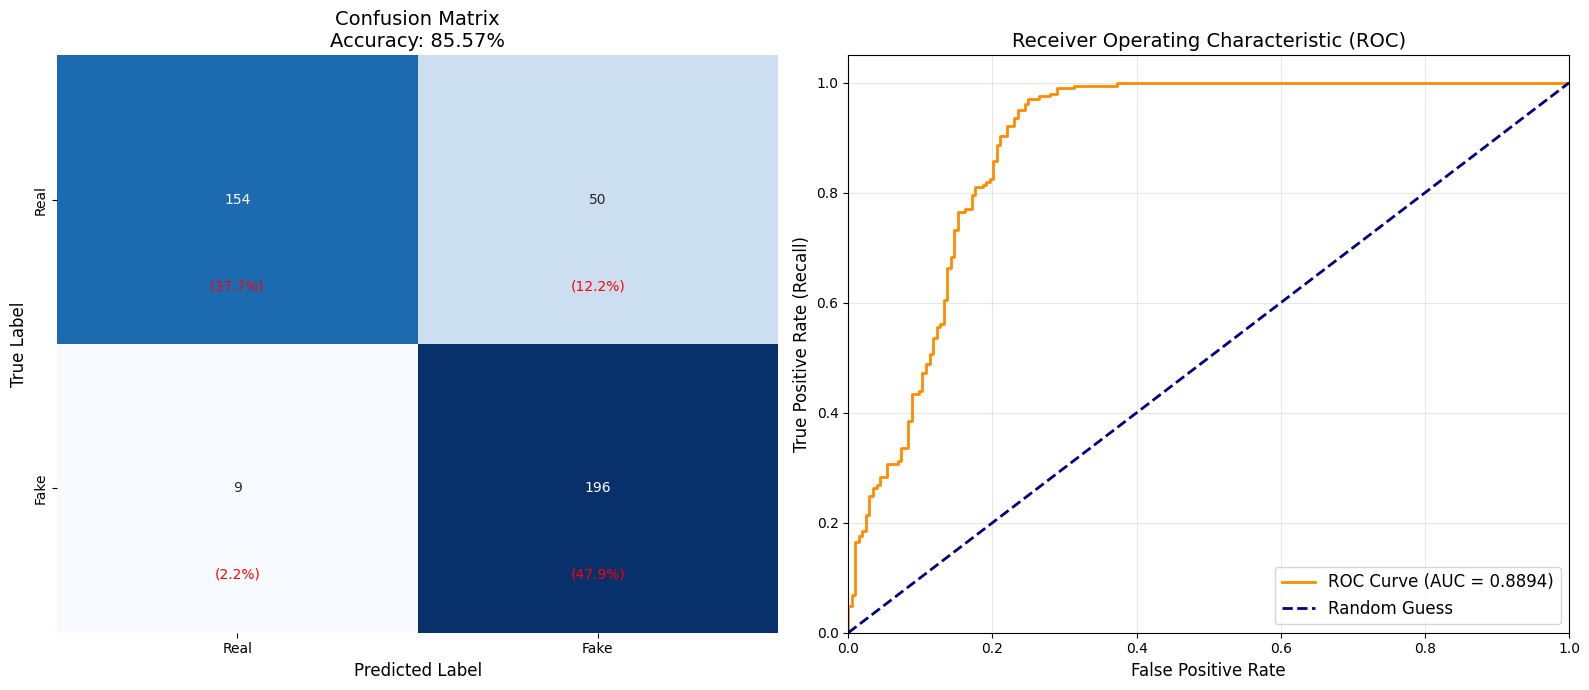


✓ Results visualization saved as: evaluation_results_final.png
✓ Final AUC-ROC Score: 0.8894


In [16]:
# ============================================================
# CELL 13: MODEL EVALUATION (DIRECT MEMORY USE)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, roc_curve, auc)

print("=" * 60)
print("EVALUATING MODEL (USING IN-MEMORY MODEL)")
print("=" * 60)

# --- 1. CHECK IF MODEL EXISTS ---
# Since we removed load_model, we must ensure the model is currently active.
if 'model' not in globals() and 'model' not in locals():
    raise ValueError("❌ Error: No model found in memory! Please run the training cell first.")
else:
    print("✓ Model found in memory. Proceeding with evaluation...")

# --- 2. EVALUATE ON TEST SET ---
print("\nEvaluating on test set...")

test_results = model.evaluate(
    x=[X_test_frames, X_test_residues],
    y={
        'class_output': y_test_array,
        'features_output': y_test_features
    },
    batch_size=16,
    verbose=1
)

# Extract basic metrics
# Note: Indices [0]=total_loss, [1]=class_loss, [2]=feat_loss, [3]=class_acc
test_loss = test_results[0]
test_class_acc = test_results[3] 

print("\n" + "=" * 60)
print(f"TEST SET PERFORMANCE")
print("=" * 60)
print(f"  Total Loss: {test_loss:.4f}")
print(f"  Classification Accuracy: {test_class_acc:.4f} ({test_class_acc*100:.2f}%)")


# --- 3. GENERATE PREDICTIONS ---
print("\nGenerating detailed predictions...")
predictions = model.predict(
    [X_test_frames, X_test_residues],
    batch_size=16,
    verbose=1
)

# Prepare labels
y_pred_probs = predictions[0]               # Probabilities [Real_prob, Fake_prob]
y_pred_classes = np.argmax(y_pred_probs, axis=1) # 0=Real, 1=Fake
y_true_classes = np.argmax(y_test_array, axis=1) # 0=Real, 1=Fake


# --- 4. CLASSIFICATION METRICS ---
print("\n" + "=" * 60)
print("DETAILED METRICS")
print("=" * 60)

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nPer-Class Breakdown:")
classes = ['Real (0)', 'Fake (1)']
for i, cls in enumerate(classes):
    print(f"  {cls}:")
    print(f"    Precision: {precision[i]:.4f}")
    print(f"    Recall:    {recall[i]:.4f}")
    print(f"    F1-Score:  {f1[i]:.4f}")

# Macro Averages
print(f"\nMacro Avg F1-Score: {f1_score(y_true_classes, y_pred_classes, average='macro'):.4f}")


# --- 5. VISUALIZATION: CONFUSION MATRIX & ROC CURVE ---
# Create a figure with 2 subplots (Side by Side)
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# === PLOT 1: CONFUSION MATRIX ===
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Real', 'Fake'], 
    yticklabels=['Real', 'Fake'],
    cbar=False,
    ax=ax[0]
)
ax[0].set_xlabel('Predicted Label', fontsize=12)
ax[0].set_ylabel('True Label', fontsize=12)
ax[0].set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}', fontsize=14)

# Add percentage text to Confusion Matrix
total = np.sum(cm)
for i in range(2):
    for j in range(2):
        p = cm[i, j] / total * 100
        ax[0].text(j+0.5, i+0.8, f'({p:.1f}%)', 
                   ha='center', va='center', color='red', fontsize=10)


# === PLOT 2: ROC CURVE ===
# Calculate ROC curve and AUC
# We use probabilities of class 1 (Fake)
fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred_probs[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate', fontsize=12)
ax[1].set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax[1].set_title('Receiver Operating Characteristic (ROC)', fontsize=14)
ax[1].legend(loc="lower right", fontsize=12)
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_results_final.png', dpi=300)
plt.show()

print(f"\n✓ Results visualization saved as: evaluation_results_final.png")
print(f"✓ Final AUC-ROC Score: {roc_auc:.4f}")

CREATING ADVANCED VISUALIZATIONS

[1/4] Creating ROC Curve...


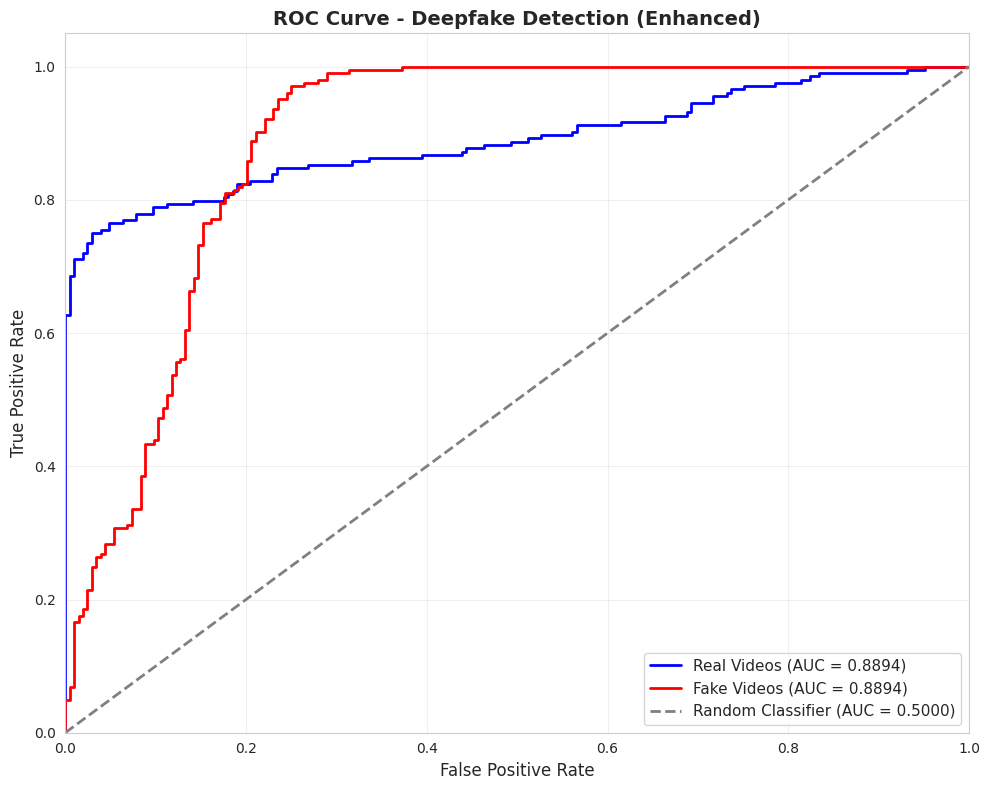

✓ ROC Curve saved
  - Real Videos AUC: 0.8894
  - Fake Videos AUC: 0.8894
  - Average AUC: 0.8894

[2/4] Creating Precision-Recall Curve...


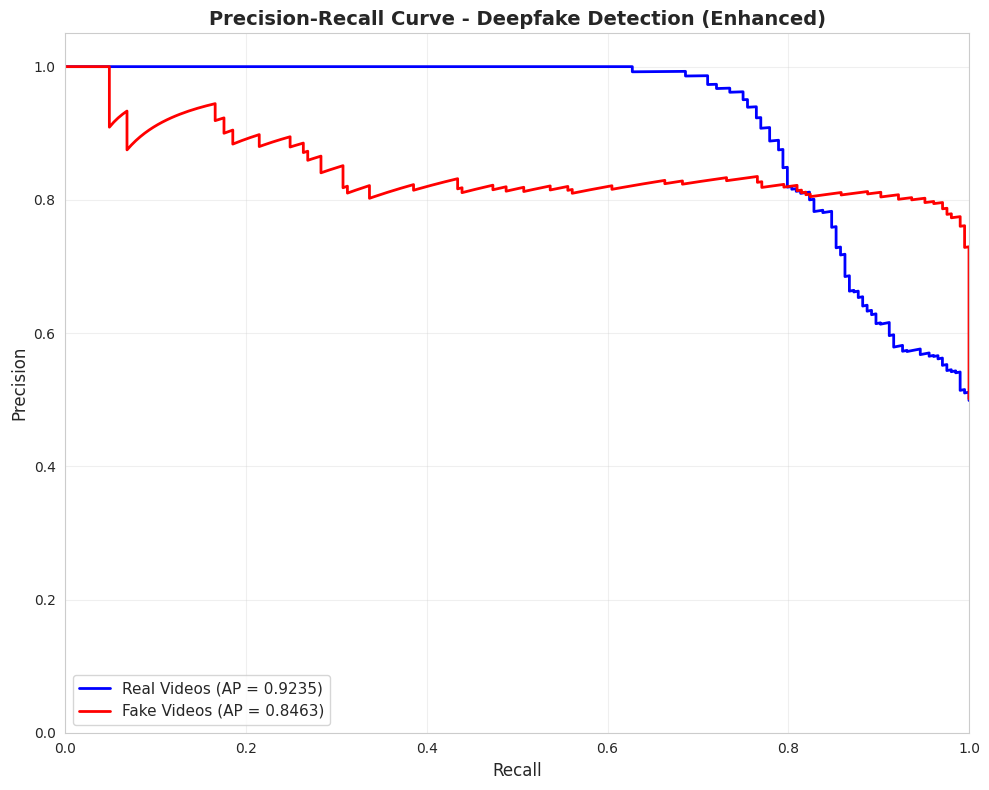

✓ Precision-Recall Curve saved
  - Real Videos AP: 0.9235
  - Fake Videos AP: 0.8463

[3/4] Creating Training History Plots...


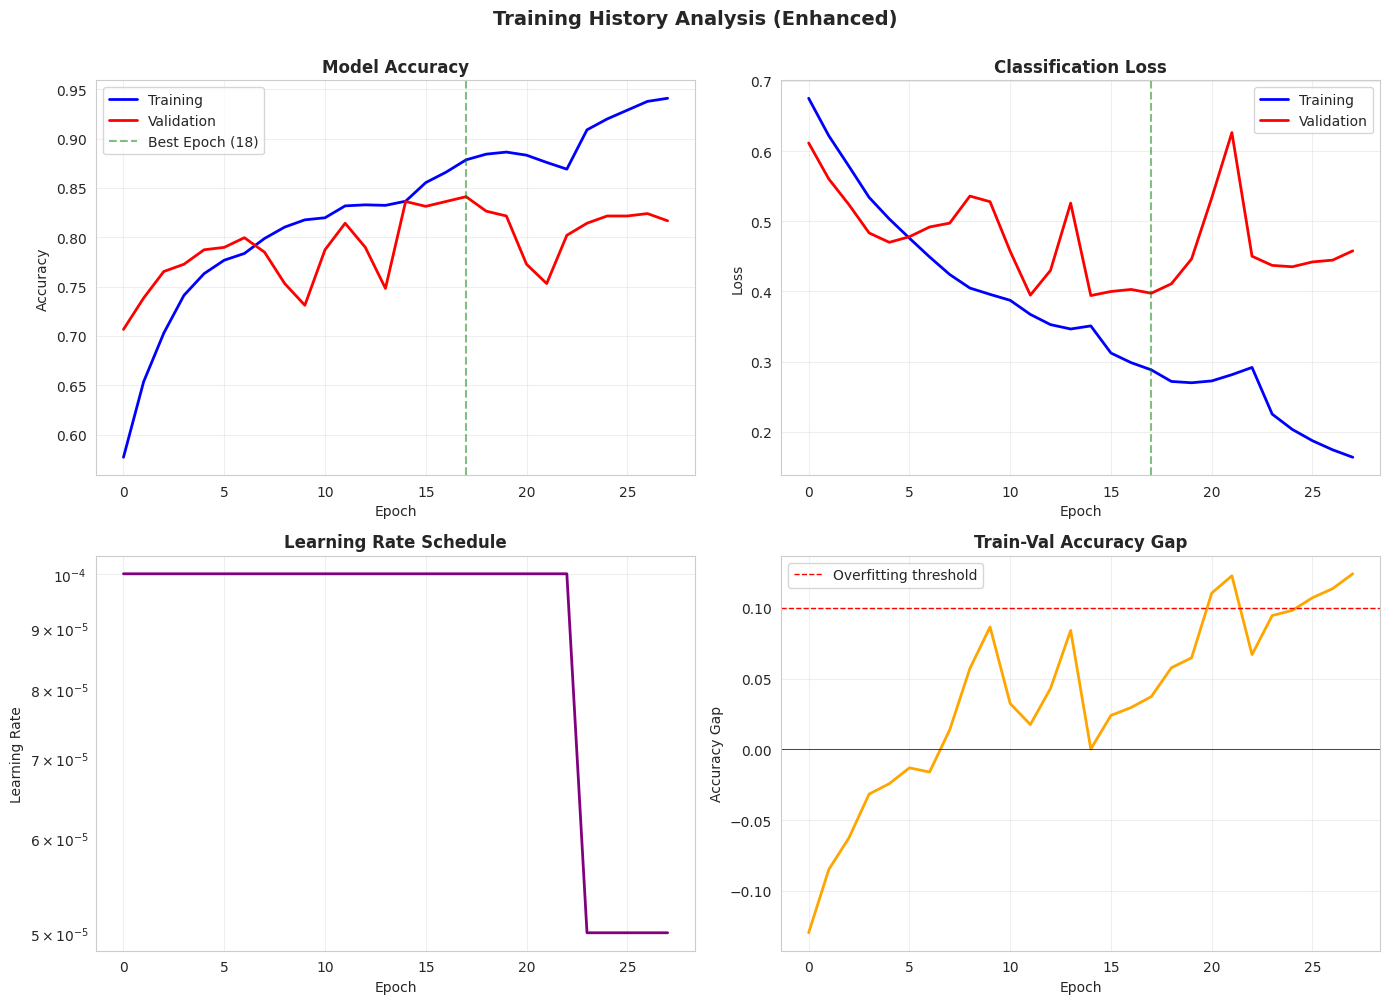

✓ Training History saved

[4/4] Creating Metrics Summary...


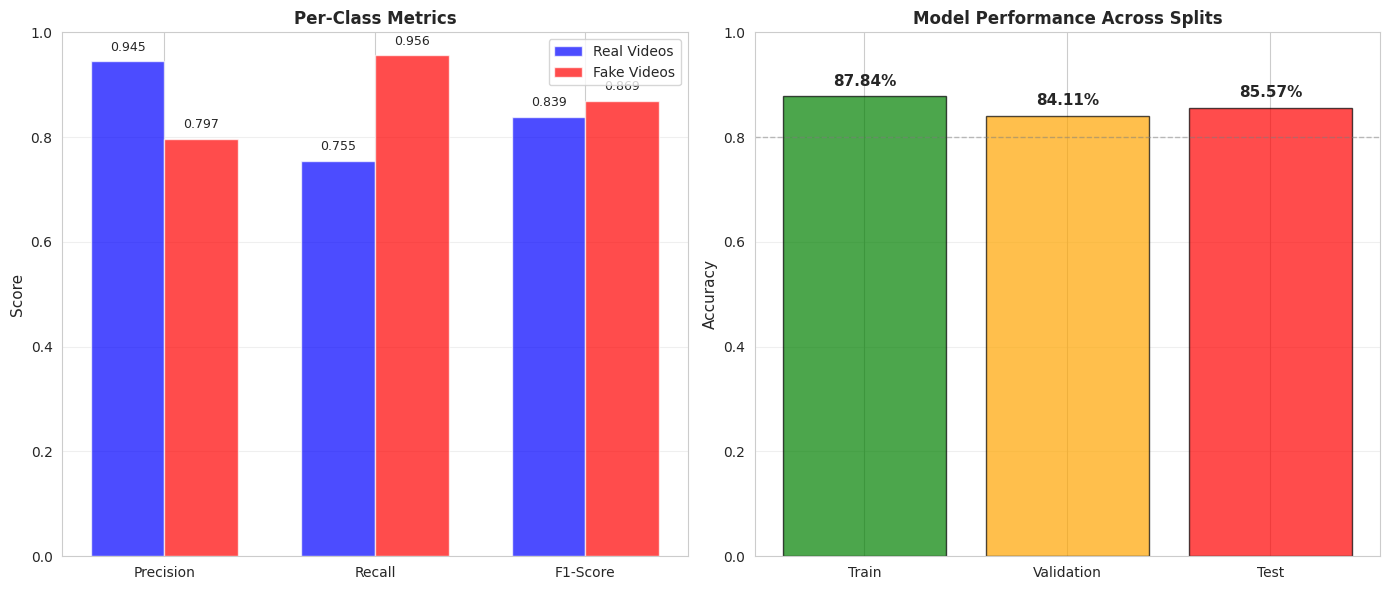

✓ Metrics Summary visualization saved

FINAL ENHANCED MODEL SUMMARY

Test Set Accuracy: 0.8557 (85.57%)
Test Set AUC-ROC: 0.8894

✓ Test results saved to: test_results_enhanced.json
✓ EVALUATION COMPLETED!


In [19]:
# ============================================================
# CELL 14: ADVANCED VISUALIZATIONS & ROC CURVES (FIXED)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import pandas as pd
import json

print("=" * 60)
print("CREATING ADVANCED VISUALIZATIONS")
print("=" * 60)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

# -------------------- Get Metrics (from previous cell) --------------------
# Load history
try:
    history_df = pd.read_csv('training_history_enhanced.csv')
    best_epoch = np.argmax(history_df['val_class_output_accuracy'])
    best_val_acc = history_df['val_class_output_accuracy'][best_epoch]
    best_train_acc = history_df['class_output_accuracy'][best_epoch]
except (FileNotFoundError, KeyError):
    print("\n⚠️  Warning: Training history file not found or incomplete. Skipping history plots.")


# ============================================================
# 1. ROC CURVE
# ============================================================
print("\n[1/4] Creating ROC Curve...")

# Calculate ROC curve for each class
fpr_real, tpr_real, _ = roc_curve(y_test_array[:, 0], y_pred_probs[:, 0])
fpr_fake, tpr_fake, _ = roc_curve(y_test_array[:, 1], y_pred_probs[:, 1])

# Calculate AUC
roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_fake = auc(fpr_fake, tpr_fake)
roc_auc_avg = (roc_auc_real + roc_auc_fake) / 2

# Plot 
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curves
ax.plot(fpr_real, tpr_real, color='blue', lw=2, 
        label=f'Real Videos (AUC = {roc_auc_real:.4f})')
ax.plot(fpr_fake, tpr_fake, color='red', lw=2, 
        label=f'Fake Videos (AUC = {roc_auc_fake:.4f})')

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
        label='Random Classifier (AUC = 0.5000)')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Deepfake Detection (Enhanced)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curve_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC Curve saved")
print(f"  - Real Videos AUC: {roc_auc_real:.4f}")
print(f"  - Fake Videos AUC: {roc_auc_fake:.4f}")
print(f"  - Average AUC: {roc_auc_avg:.4f}")

# ============================================================
# 2. PRECISION-RECALL CURVE
# ============================================================
print("\n[2/4] Creating Precision-Recall Curve...")

# Calculate PR curve for each class
precision_real, recall_real, _ = precision_recall_curve(y_test_array[:, 0], y_pred_probs[:, 0])
precision_fake, recall_fake, _ = precision_recall_curve(y_test_array[:, 1], y_pred_probs[:, 1])

# Calculate Average Precision
ap_real = average_precision_score(y_test_array[:, 0], y_pred_probs[:, 0])
ap_fake = average_precision_score(y_test_array[:, 1], y_pred_probs[:, 1])

# Plot 
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(recall_real, precision_real, color='blue', lw=2, 
        label=f'Real Videos (AP = {ap_real:.4f})')
ax.plot(recall_fake, precision_fake, color='red', lw=2, 
        label=f'Fake Videos (AP = {ap_fake:.4f})')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve - Deepfake Detection (Enhanced)', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('precision_recall_curve_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Precision-Recall Curve saved")
print(f"  - Real Videos AP: {ap_real:.4f}")
print(f"  - Fake Videos AP: {ap_fake:.4f}")

# ============================================================
# 3. TRAINING HISTORY VISUALIZATION (Requires history_df)
# ============================================================
print("\n[3/4] Creating Training History Plots...")

if 'history_df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Accuracy 
    axes[0, 0].plot(history_df['class_output_accuracy'], label='Training', color='blue', linewidth=2)
    axes[0, 0].plot(history_df['val_class_output_accuracy'], label='Validation', color='red', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    if 'best_epoch' in locals():
        axes[0, 0].axvline(best_epoch, color='green', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch+1})')
        axes[0, 0].legend()

    # Loss
    axes[0, 1].plot(history_df['class_output_loss'], label='Training', color='blue', linewidth=2)
    axes[0, 1].plot(history_df['val_class_output_loss'], label='Validation', color='red', linewidth=2)
    axes[0, 1].set_title('Classification Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    if 'best_epoch' in locals():
        axes[0, 1].axvline(best_epoch, color='green', linestyle='--', alpha=0.5)

    # Learning Rate
    if 'learning_rate' in history_df.columns:
        axes[1, 0].plot(history_df['learning_rate'], color='purple', linewidth=2)
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'LR Data Not Available', ha='center', va='center')

    # Accuracy Gap (Overfitting indicator)
    acc_gap = history_df['class_output_accuracy'] - history_df['val_class_output_accuracy']
    axes[1, 1].plot(acc_gap, color='orange', linewidth=2)
    axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[1, 1].axhline(0.1, color='red', linestyle='--', linewidth=1, label='Overfitting threshold')
    axes[1, 1].set_title('Train-Val Accuracy Gap', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Gap')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Training History Analysis (Enhanced)', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('training_history_detailed_enhanced.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Training History saved")
else:
    print("\n❌ Skipping training history plots (history data unavailable).")


# ============================================================
# 4. FINAL SUMMARY AND DATA SAVING
# ============================================================
print("\n[4/4] Creating Metrics Summary...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot: Per-class metrics 
metrics_data = {
    'Real Videos': [precision[0], recall[0], f1[0]],
    'Fake Videos': [precision[1], recall[1], f1[1]]
}

x = np.arange(3)
width = 0.35

axes[0].bar(x - width/2, metrics_data['Real Videos'], width, label='Real Videos', color='blue', alpha=0.7)
axes[0].bar(x + width/2, metrics_data['Fake Videos'], width, label='Fake Videos', color='red', alpha=0.7)

axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Per-Class Metrics', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Precision', 'Recall', 'F1-Score'])
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add values on bars (This was the fixed part)
for i, (metric_real, metric_fake) in enumerate(zip(metrics_data['Real Videos'], metrics_data['Fake Videos'])):
    axes[0].text(i - width/2, metric_real + 0.02, f'{metric_real:.3f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, metric_fake + 0.02, f'{metric_fake:.3f}', ha='center', fontsize=9)

# Performance across splits
split_performance = {
    'Train': best_train_acc if 'best_train_acc' in locals() else accuracy, # Fallback to test if history is missing
    'Validation': best_val_acc if 'best_val_acc' in locals() else accuracy,
    'Test': accuracy
}

axes[1].bar(split_performance.keys(), split_performance.values(), 
            color=['green', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Model Performance Across Splits', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].axhline(0.8, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (split, acc) in enumerate(split_performance.items()):
    axes[1].text(i, acc + 0.02, f'{acc:.2%}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_summary_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Metrics Summary visualization saved")

# -------------------- FINAL REPORT SUMMARY --------------------
print("\n" + "=" * 60)
print("FINAL ENHANCED MODEL SUMMARY")
print("=" * 60)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy:.2%})")
print(f"Test Set AUC-ROC: {roc_auc_avg:.4f}")

# Save results dictionary
results_dict = {
    'test_accuracy': accuracy,
    'test_auc_roc': roc_auc_avg,
    'test_precision_real': precision[0],
    'test_precision_fake': precision[1],
    'test_recall_real': recall[0],
    'test_recall_fake': recall[1],
    'test_f1_real': f1[0],
    'test_f1_fake': f1[1],
    'confusion_matrix': cm.tolist()
}

with open('test_results_enhanced.json', 'w') as f:
    json.dump(results_dict, f, indent=4)

print("\n✓ Test results saved to: test_results_enhanced.json")
print("✓ EVALUATION COMPLETED!")
print("=" * 60)

In [20]:
# ============================================================
# CELL 15: FINAL RESULTS - NUMBERS ONLY
# ============================================================

from sklearn.metrics import roc_curve, auc

print("=" * 60)
print("           FINAL MODEL PERFORMANCE (ENHANCED)")
print("=" * 60)

# -------------------- ACCURACY --------------------
print(f"""
ACCURACY:
  Training:    {best_train_acc:.4f} ({best_train_acc*100:.2f}%)
  Validation:  {best_val_acc:.4f} ({best_val_acc*100:.2f}%)
  Test:        {accuracy:.4f} ({accuracy*100:.2f}%)
""")

# -------------------- CONFUSION MATRIX --------------------
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

print(f"""
CONFUSION MATRIX:
              Real  Fake
  Real:       {tn:3d}   {fp:3d}
  Fake:       {fn:3d}   {tp:3d}

  True Negatives:   {tn} ({tn/total*100:.1f}%)
  False Positives:  {fp} ({fp/total*100:.1f}%)
  False Negatives:  {fn} ({fn/total*100:.1f}%)
  True Positives:   {tp} ({tp/total*100:.1f}%)
""")

# -------------------- ROC-AUC --------------------
fpr_real, tpr_real, _ = roc_curve(y_test_array[:, 0], y_pred_probs[:, 0])
fpr_fake, tpr_fake, _ = roc_curve(y_test_array[:, 1], y_pred_probs[:, 1])

roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_fake = auc(fpr_fake, tpr_fake)
roc_auc_avg = (roc_auc_real + roc_auc_fake) / 2

print(f"""
ROC-AUC:
  Real Videos:  {roc_auc_real:.4f}
  Fake Videos:  {roc_auc_fake:.4f}
  Average:      {roc_auc_avg:.4f}
""")

print("=" * 60)
print("✓ EVALUATION COMPLETED")
print("=" * 60)

           FINAL MODEL PERFORMANCE (ENHANCED)

ACCURACY:
  Training:    0.8784 (87.84%)
  Validation:  0.8411 (84.11%)
  Test:        0.8557 (85.57%)


CONFUSION MATRIX:
              Real  Fake
  Real:       154    50
  Fake:         9   196

  True Negatives:   154 (37.7%)
  False Positives:  50 (12.2%)
  False Negatives:  9 (2.2%)
  True Positives:   196 (47.9%)


ROC-AUC:
  Real Videos:  0.8894
  Fake Videos:  0.8894
  Average:      0.8894

✓ EVALUATION COMPLETED
